# Finding spam in Youtube comments.   

Spam has been around since the beginning of the internet.  In fact, the use of spam over a network stretches back all the way to 1884 when wealthy Americans were sent unsolicited investment offers over the telegraph[[1](http://content.time.com/time/business/article/0,8599,1933796,00.html)].  In more modern times, the first appearence of modern email spam occured on ARPANET, a military precurser to the internet, when 'a man named Gary Turk sent an e-mail solicitation to 400 people, advertising his line of new computers'[[1](http://content.time.com/time/business/article/0,8599,1933796,00.html)].  

In this notebook we will consider filtering the problem of finding spam in Youtube comments.   Spam in youtube comments is a slightly different task then spam in email.  Youtube comments tend to be short, often less than five words, and a spam email may simply contain the name the website domain.   However, as we will see, it is quite easy to construct a machine learning model to classify comments as spam or ham (not spam).   

For a training and test set, we will use the spam database found on the  UCI machine learning repository.   There are several different types of algorithm we can use to classify spam, however in this notebook, I will compare three specific models

* Logistic Regression
* Naive Bayes Classifier
* Recurrent Neural Networks

While simple, the logistic regression and naive Bayes models perform quite well at classifying emails as spam or ham, and manage to achieve an f1 score of ~.9 on the test set.  The neural network performs well, though not as good as the Naive Bayes algorithm, with an f1 score of .75 on the test set.   

## Table of Contents 
* [Data preprocessing](#1)
    * [Cleaning the data](#1.1)
    * [Splitting the data into test/training sets](#1.2)
* [Turning sentences into vectors](#2)
    * [Bag of words model](#2.1)
    * [Term frequency/inverse document frequency](#2.2)
* [Predicting spam vs ham](#3)
    * [Model evaluation criteria](#3.1)
    * [Logistic regression](#3.2)
    * [Naive Bayes model](#3.3)
* [Neural networks](#4)
    * [Word encodings](#4.1)
    * [Recurrent neural networks](#4.2)
* [Conclusions](#5)
    

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import os

# Data analysis, preprocessing <a id='1'></a>

[UCI has a machine learning repository consisting of comments from five youtube videos that are classified as spam or not spam](http://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection#).   These are stored as csv_files, which will be loaded into a list of dataframes.   The classification data is stored as the class field, where comments with a class of 1 are considered spam, and comments with a class value of 0 are ham.   

In [39]:
file_names = ['Youtube01-Psy.csv','Youtube02-KatyPerry.csv','Youtube03-LMFAO.csv',
              'Youtube04-Eminem.csv','Youtube05-Shakira.csv']
filepath = './data'
dataframes = [pd.read_csv(os.path.join(filepath,file_name)) for file_name in file_names]
dataframes[0].head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1


To get a better sense of the data, let us print out the content for several reviews.

In [3]:
for content in dataframes[0].CONTENT[14:20]:
    print(content)

please like :D https://premium.easypromosapp.com/voteme/19924/616375350﻿
Hello! Do you like gaming, art videos, scientific experiments, tutorials,  lyrics videos, and much, much more of that? If you do please check out our  channel and subscribe to it, we've just started, but soon we hope we will  be able to cover all of our expectations... You can also check out what  we've got so far!﻿
I'm only checking the views﻿
http://www.ebay.com/itm/171183229277?ssPageName=STRK:MESELX:IT&amp;_trksid=p3984.m1555.l2649 ﻿
http://ubuntuone.com/40beUutVu2ZKxK4uTgPZ8K﻿
We are an EDM apparel company dedicated to bringing you music inspired  designs. Our clothing is perfect for any rave or music festival. We have  NEON crop tops, tank tops, t-shirts, v-necks and accessories! follow us on  Facebook or on instagraml for free giveaways news and more!! visit our site  at OnCueApparel﻿


### Cleaning the data <a id='1.1'></a>
We see that there are several features we don't need such as COMMENT_ID, AUTHOR, and DATE.   We also see that within content, there are a lot of web links.   To make it easier to identify weblinks, we will substitute in the word WEBLINK for every instance of a URL.   The character /ufeff is also present in the file, which is most likely due to improperly decoding utf-16 as utf-8.   We define a function to remove this.   

In [4]:
def format_sentence(s):
    ret_sent = re.sub('http\S+','WEBLINK',s)
    ret_sent = re.sub(r'\\ufeff','',ret_sent)
    return ret_sent

### Splitting the data into test and training sets <a id='1.2'></a>
We will want to be able to test our data, so we will split the data into a test and training set.  The training set will be used along with cross validation to select the best model.  The model will then be evaluated by testing it on the test dataset.   

In [5]:
from sklearn.model_selection import train_test_split
data = pd.concat(dataframes).reset_index(drop=True)
X_train,X_test,y_train,y_test = train_test_split(data.CONTENT,data.CLASS)

## Turning the sentences into useable vectors <a id='2'></a>
If we want to use a machine learning algorithm to predict the number of sentences, then we need to find a mapping that will associate every word, and every sentence with a vector that we then can feed into our machine learning algorithm.   The simplest way to do this is to use the Bag of words model, or create vectors by finding the term-frequency inverse-document-frequency of each sentence.   

### Bag of words Model <a id='2.1'></a>
We will first use a bag of words model to turn each sentence into a unique vector.   The bag of words model is simply turning each word into a basis vector in a Hilbert space.  To form a vector for the words, we simply add the vectors for each word for each sentence.  Thus each sentence will be transformed into a vector that we can add to a machine learning model.  In this model, if we had the sentences 
* 'I ran to the store',
* 'I ran across town',
* 'I ran to work and to home',

then we could form a basis set of the vectors ('I','ran','to','the','store','across','town','work','and','home').   The sentences would then be encoded as the vectors 
* (1,1,1,1,1,0,0,0,0,0)
* (1,1,0,0,0,1,1,0,0,0)
* (1,1,2,0,0,0,0,1,1,1)

However, this model can still be improved.  For example, the words 'the', 'a', and 'of' occur so often that they are unlikely to help us classify comment.   These words that are common enough that they do not aid in distinguishing sentences are called stopwords.   Another limitation is that our implementation above would classify 'bag' and 'bags' as two different words.   For this bag-of-words model, we don't care about the verb tense or the s at the end of a word.  What we want to do is associate every word with a stem, that represents its most basic feature. ie. 'run' and 'running', and 'runs' might all be replaced by the same word 'ru'.  To achieve this, we will use a porter stemmer, which is found in the nltk.

Another limitation is that words that only occur once during the document do not add any predictive power.  Because of this, we will ignore any words that occur less than five times.  

### TFIDF <a id='2.2'></a>
The vectors are not normalized now, and in fact can be improved using one more feature which mapping each count in a vector to its term frequency/inverse document frequency.   A term which appears five times in one comment is likely important.  This is referred to as the document frequency.  However, if that same term appears five times in every comment, then it is likely a commonly used word, 'the' for example.  This is the document frequency  The term frequency/inverse document frequency is simply the ratio of the term frequency to the inverse document frequency.   The precise definition is to let the number of times a term $t$ appears in document $d$ be $tf(t,d)$.   Let $n_d$ be the total number of documents in the corpus, and let $df(t)$ be the number of documents containing term $t$.  Then the term-frequency calculated in the sklearn TfidfVectorizer is $tfidf(t,d)$ is $$tfidf(t,d) = tf(t,d)\cdot\text{log}\left(\frac{1+n_d}{1+df(t)}+1\right)$$  (Note, this differs slightly from the tfidf given in textbooks).  The resulting vectors are then normalized.    


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
def port_tokenizer(text):
    words = re.split(r'\s+',text.lower())
    ps = PorterStemmer()
    return [ps.stem(word) for word in words if not word in nltk.corpus.stopwords.words('english') and word]
count_vect = CountVectorizer(preprocessor=format_sentence,tokenizer=port_tokenizer,min_df=5)
tfidf_vect = TfidfVectorizer(preprocessor=format_sentence,tokenizer=port_tokenizer,min_df=5)
X_train_bow = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
print(X_train_bow.shape)

(1467, 394)


## Predicting spam vs ham <a id='3'></a>

### Model evaluation criteria <a id='3.1'></a>
Now that we have transformed our sentences into feature vectors, we can try several machine learning algorithms to predict whether or not a given word will be spam.  We also will need a way to evaluate our results.  Since in the real world, spam occurs infrequently compared to ham, a classifier which simply predicted everything as ham would have a high accuracy.  Because of this, accuracy is not the prefered way to measure the performance of a spam classifier.  Instead we will use a combination of precision and recall 
- precision: The number of true positives divided by the number of elements predicted to be true (true and false positives)
- recall: The number of true positives divided by the number of all positives (true positives and false negatives)
Since we want to maximize both of these at the same time, we will use the f1-score, which is defined as the product of precision and recall, divided by their mean.  $$f_1 = \frac{\text{precision}\cdot\text{recall}}{(\text{precision}+\text{recall})/2}$$


In [7]:
from sklearn.metrics import f1_score

### Logistic Regression <a id='3.2'></a>
The simplest model we could use to predict spam would be a logistic regression.   The logistic regression model will choose its parameters via a grid search which will alter the regularization term C.   We will also try using both the bag of words, and the tfidf vectors. 

C:\Users\Michael\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Michael\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'C': 1.681792830507429}
0.9327579180012385


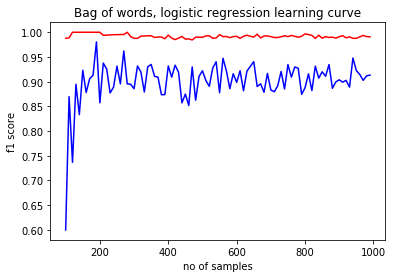

Test Set f1-score: 0.923


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
course_params = {'C':[2**x for x in range(-6,15,2)]}
gs = GridSearchCV(LogisticRegression(class_weight='balanced'),course_params,n_jobs=-1,cv=5,scoring='f1')
gs.fit(X_train_bow,y_train)
fine_params = {'C':[gs.best_params_['C']*(2**x) for x in np.arange(-1.75,2,.25)]}
gs = GridSearchCV(LogisticRegression(class_weight='balanced'),fine_params,n_jobs=-1,cv=5,scoring='f1')
gs.fit(X_train_bow,y_train)
print(gs.best_params_)
print(gs.best_score_)
sample_sizes = range(100,1000,10)
train_bow,test_bow = list(),list()
lr_bow = LogisticRegression(class_weight='balanced',C=gs.best_params_['C'])
for sample_size in sample_sizes:
    xs,ys= X_train[:sample_size],y_train[:sample_size]
    count_vect = CountVectorizer(preprocessor=format_sentence,tokenizer=port_tokenizer)
    xs_bow = count_vect.fit_transform(xs)
    xs_train,xs_test,ys_train,ys_test = train_test_split(xs_bow,ys)
    lr_bow.fit(xs_train,ys_train)
    train_bow.append(f1_score(lr_bow.predict(xs_train),ys_train))
    test_bow.append(f1_score(lr_bow.predict(xs_test),ys_test))
plt.plot(sample_sizes,train_bow,c='r',label='training')
plt.plot(sample_sizes,test_bow,c='b',label='test')
plt.xlabel('no of samples')
plt.ylabel('f1 score')
plt.title('Bag of words, logistic regression learning curve')
plt.show()
Xs_test = count_vect.transform(X_test)
print("Test Set f1-score: {:.3}".format(f1_score(lr_bow.predict(Xs_test),y_test)))

{'C': 4.7568284600108841}
0.9218904914610436


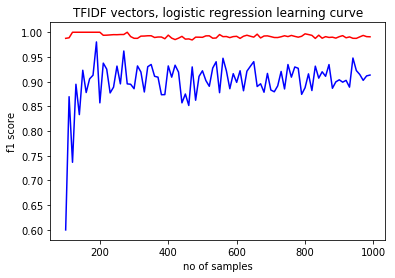

Test Set f1-score: 0.944


In [9]:
course_params = {'C':[2**x for x in range(-6,15,2)]}
gs = GridSearchCV(LogisticRegression(class_weight='balanced'),course_params,n_jobs=-1,cv=5,scoring='f1')
gs.fit(X_train_tfidf,y_train)
fine_params = {'C':[gs.best_params_['C']*(2**x) for x in np.arange(-1.75,2,.25)]}
gs = GridSearchCV(LogisticRegression(class_weight='balanced'),fine_params,n_jobs=-1,cv=5,scoring='f1')
gs.fit(X_train_tfidf,y_train)
print(gs.best_params_)
print(gs.best_score_)
sample_sizes = range(100,1000,10)
train_tfidf,test_tfidf = list(),list()
lr_tfidf = LogisticRegression(class_weight='balanced',C=gs.best_params_['C'])
for sample_size in sample_sizes:
    xs,ys= X_train[:sample_size],y_train[:sample_size]
    tfidf_vect = TfidfVectorizer(preprocessor=format_sentence,tokenizer=port_tokenizer)
    xs_tfidf = tfidf_vect.fit_transform(xs)
    xs_train,xs_test,ys_train,ys_test = train_test_split(xs_tfidf,ys)
    lr_tfidf.fit(xs_train,ys_train)
    train_tfidf.append(f1_score(lr_tfidf.predict(xs_train),ys_train))
    test_tfidf.append(f1_score(lr_tfidf.predict(xs_test),ys_test))
plt.plot(sample_sizes,train_bow,c='r',label='training')
plt.plot(sample_sizes,test_bow,c='b',label='test')
plt.xlabel('no of samples')
plt.ylabel('f1 score')
plt.title('TFIDF vectors, logistic regression learning curve')
plt.show()
Xs_test = tfidf_vect.transform(X_test)
print("Test Set f1-score: {:.3}".format(f1_score(lr_tfidf.predict(Xs_test),y_test)))

We can see that the simple bow model gets a slightly higher f1 score then the tfidf.  We can also note that because of the large dimension of the feature space, that the model achieves near perfect accuracy on the training set.   

### Bayesian spam filtering <a id='3.3'></a>

Bayesian spam filtering is one of the oldest types of spam filtering out there.   The original papers covering this method were first published in 1998 [[2](http://www.paulgraham.com/better.html)].   However, further improvements came in 2003, when Paul Graham published an article in which he devised a better way to classify spam emails [[2](http://www.paulgraham.com/better.html)].   

For this section, we will rely on the most simple version of a Bayesian spam filter we can create.  We will start by initially representing sentences as a set of unique words.  What we want to know is the probability that a message is spam given its set of words $P(S\mid\{w_1,w_2,...,w_n\})$, or the probability that a message is ham given its words $P(H\mid\{w_1,w_2,...,w_n\})$.   Using Bayes rule, we can rewrite these probabilities as $$P(s\mid\{w_1,w_2,...\}) \propto P(\{w_1,w_2,...\}\mid s)P(s) $$ where $s$ represents either spam or ham.   

While this expression is not terribly enlightening, if we will make the assumption that the probability of each word appearing is independent, ie. $$P(\{w_1,w_2,...,w_n\}) = \prod_iP(w_i)$$
then we can rewrite the probability as $$P(s\mid\{w_1,w_2,...w_n\})\propto P(\{w_1,w_2,...,w_n\}\mid s)P(s) = \left(\prod_iP(w_i\mid s)\right) P(s)$$ where $s$ represent either Spam or Ham.    While this assumption is no doubt not false since there are correlations between the frequencies of words, it allows us to write an easily calculable expression for the probability of a word being spam.   In addition, as we will see, the assumption turns out to yield decent results.   

However, when we use this method, we still have the problem of words with zero frequency showing up.   To deal with this we will use laplace (add 1) smoothing where we define $$p(w_i\mid s) = \frac{\text{count}_s(w_i)+1}{\sum_j \text{count}(w_j)+1} $$ where count$_s(w_i)$ is the number of messages in $s$ that contain the word $w_i$.    To avoid floating-point underflow, we typically calculate $$\text{log}\,P(s\mid\{w_1,...,w_n\}) = \text{log}P(s)+\sum_{i=1}^N\text{log}P(w_i,s) $$ rather than $P(s\mid\{w_1,...w_n\})$

To avoid the problem of rare words, we will also include a minimum document frequency necessary for us to consider a word.  We will then make predictions based on whether or not the log probability of the email being ham is greater than the log probability of the email being spam, however, we could also adjust the cutoff quite easily 



the f1 score on the training set is: 0.86 +/- 0.03


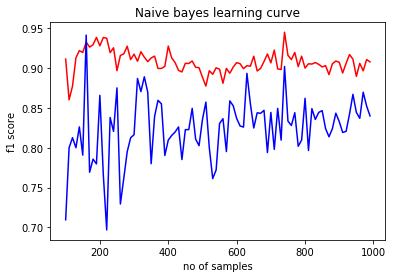

The f1 score on the test set is 0.84


In [10]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
class BayesianSpamClassifier(BaseEstimator):
    """Provides a bayesian estimator of whether or """
    def __init__(self,min_df=5):
        self.min_df = min_df
    def fit(self,X,y):
        spam = X[y.values.astype(bool)]>0
        ham = X[~y.values.astype(bool)]>0
        self.ham= ham
        self.spam=spam
        self.valid_indices = (X.sum(axis=0)>=self.min_df).astype(bool)
        prob_word_given_spam = (spam.sum(axis=0)+1)/((spam.sum(axis=0)+1).sum())
        self.prob_word_given_spam = prob_word_given_spam[self.valid_indices]
        prob_word_given_ham = (ham.sum(axis=0)+1)/((ham.sum(axis=0)+1).sum())
        self.prob_word_given_ham = prob_word_given_ham[self.valid_indices]
        self.prob_spam = y.sum()/y.shape[0]
        self.prob_ham = 1-self.prob_spam
    def predict(self,X):
        prob_ham = self.prob_ham
        prob_spam = self.prob_spam
        prob_word_given_spam = self.prob_word_given_spam
        prob_word_given_ham = self.prob_word_given_ham
        X = X[:,self.valid_indices]>0
        log_prob_ratio_spam_ham = X.dot(np.log((prob_word_given_spam.T)/(prob_word_given_ham.T)))+np.log(prob_spam/prob_ham)
        return log_prob_ratio_spam_ham>0
cv = cross_val_score(BayesianSpamClassifier(2),X_train_bow.toarray(),y_train,
                     cv=10,scoring='f1')
print('the f1 score on the training set is: {:.2f} +/- {:.2f}'.format(cv.mean(),cv.std()))

train_bow=list()
test_bow=list()
for sample_size in sample_sizes:
    xs,ys= X_train[:sample_size],y_train[:sample_size]
    bc_bow =BayesianSpamClassifier(2)
    count_vect = CountVectorizer(preprocessor=format_sentence,tokenizer=port_tokenizer)
    xs_bow = count_vect.fit_transform(xs)
    xs_train,xs_test,ys_train,ys_test = train_test_split(xs_bow,ys)
    bc_bow.fit(xs_train.toarray(),ys_train)
    train_bow.append(f1_score(bc_bow.predict(xs_train.toarray()),ys_train))
    test_bow.append(f1_score(bc_bow.predict(xs_test.toarray()),ys_test))
plt.plot(sample_sizes,train_bow,c='r',label='training')
plt.plot(sample_sizes,test_bow,c='b',label='test')
plt.xlabel('no of samples')
plt.ylabel('f1 score')
plt.title('Naive bayes learning curve')
plt.show()
xs_test = count_vect.transform(X_test)
print("The f1 score on the test set is {:.2f}".format(f1_score(bc_bow.predict(xs_test),y_test)))

We can see that with this incredibly simple Bayesian classifier, we can achieve a high f1 score on the training set.   

## Neural networks for spam classification <a id='4'></a> 

We can also take a deep learning approach to spam classification.  There are several approaches to classifying spam using neural networks; however, the model I will use for text classification will be a simple recurrent neural network (RNN) modeled in tensorflow.  An RNN is a type of neural network that allows us to model sequences of arbitrary lengths using one set of parameters.   The basic setup for one is show below: ![A simple RNN](images/rnn.png)
**source: cs224 at stanford lecture notes, [[3](http://cs224d.stanford.edu)]**

The inputs $x_i$ are individual vectors representing each word.   Each node in the RNN takes two inputs, $x_i$ which represents the input of the $i$th word vector, and $h_{i-1}$ which represents the output from the $i-1$th node.   The nodes in tern generate two outputs, $y_i$ and $h_i$, where $h_i$ is than fed in as an input to the next node.   The nodes furthermore all share the same matrices, $W_{hh}$, $W_{xh}$, and $W_S$, which are used to generate the outputs.  

* $y_i = \text{softmax}(W_Sh_i)$
* $h_i = \sigma(W_{hh}h_{i-1}+W_{hx}x_i) $

where $\sigma$ is the sigmoid function.   The benefit from a neural network like this is that the output of the $i$th node depends not just on $x_i$ but also on $x_{i-1}$, $x_{i-2}$ and so on.  For sentence processing, the steps are as follows:

1. We start by encoding all of the words as vectors in a $D_w$ space, transforming an $n$ word sentence into a $n\times D_w$ tensor.  
2. We transform a sentence into a length $n_s$ vector by  feeding the sentence words into a RNN, where each output is a  $n_{s}$ vector.  We take the last output of the RNN (which depends on all words in the RNN to be the sentence vector.
3. We add in one additional layer to the neural network to map us from $n_s$ to $n_c$ where $n_c$ is the number of possible predicted labels (in this case 2).   
4. We train this neural network using gradient descent.   


We will construct this operation by using the popular library, tensorflow, to build our neural network, and gensim, to encode the word vectors.  Tensorflow is an open source package written in optimized c++ and python, which can be used to build fast neural networks.   

## Word encodings <a id='4.1'></a>

To encode the words as vectors, we will use the gensim library and its word2vec encoder.   The word2vec encoder I will use in this case determines the embeddings of a word by considering what words often occur near that word.   For example, if president and prime minister occurred often together, the resulting vectors in the embedding would also appear close together.   However, the word 'president' and the word 'prime-rib' would appear distant.   The word2vec is a useful encoder since it also can preserve analogies.  For example, the vector that points from man to king, is nearly the same as the vector that points from woman to queen, and the vector that points from cow to beef will be nearly the same as the vector that points from sheep to mutton.   

To simplify the words more, we will first use a porter tokenizer to stem and tokenize all words before creating word embeddings.  This will reduce the noise associated with our small sample size.  

In [31]:
from gensim.models import Word2Vec
format_sentence, port_tokenizer
def process_data(X,y,embedding_dim=10,sentence_length=10):
    """Loads the text data and processes it into a padded array, and returns
    the array along with sentence lengths
    
    Parameters:
    --------------
    X: iterable array, shape = [n_samples,]
        entries consist of unprocessed sentences (i.e. text)
    y: iterable array, shape = [n_samples], 
        entries consist of 0 or 1
    embedding_dim: int, default 10: the size of word vectors in the model
    sentence_length: int, default 10: the maximum sentence length to consider,
                     longer sentences will be shortened
    
    Returns:
    tuple consisting of X,y,length
    X: array, shape = [n_samples,sentence_length,embedding_dim] 
    y: array, shape = [n_samples,2]
    length:, array, shape = [n_samples]
    """
    if(type(X)!=type(pd.Series())):
        X = pd.Series(X)
    if(type(y)!=type(pd.Series())):
        y =pd.Series(y)
    X = X.apply(format_sentence)
    X = X.apply(port_tokenizer)
    wv=Word2Vec(X,size=embedding_dim).wv
    X = X.apply(lambda ls:[list(wv[word]) for word in ls if
                                              word in wv.vocab])
    lengths = X.apply(lambda x:len(x) if len(x)<sentence_length else sentence_length)
    pad = [0. for i in range(embedding_dim)]
    X = X.apply(lambda ls:[ls[i] if i<len(ls) else pad for i in range(sentence_length)])
    X = X[lengths>0]
    y = y[lengths>0]
    lengths = lengths[lengths>0]
    #One hot encode y as [ham, spam]
    y = y.apply(lambda x:[0,1] if x else [1,0])
    return list(X),list(y),list(lengths)


### Recurrent Neural Networks: <a id='4.2'></a>

The diagram for the network is shown below. ![nn](images/RNN_SPAM.jpg)

In tensorflow’s implementation of a simple RNN Cell, the outputs $y_i$ and $h_i$ are equal to each other, and are given by $$y_i=h_i =  \text{activation}(V x_i + U  h_{i-1} + b)$$ where $V$ and $U$ are matrices, and $b$ is the bias term.  The activations of the output neurons $p(s)$ are then given by $$ p(s) = \text{softmax}(W\cdot h_l+b) $$ where $h_l$ is the last output from the rnn, and $W$ is a tensor.   The predictions are made based on which class has the higher activation.  

I will construct this and then run it for some simple settings.

In [37]:
class Config():
    """ A class to hold the settings for neural network.
    """
    learning_rate=.005
    batch_size=100
    max_epochs=1000

    #length of word vectors
    n_input=20
    #max no of words per sentence
    n_steps=10
    n_classes=2
    #size of hidden RNN layer(i.e. length of sentence features)
    n_hidden=20
    #regularization parameter
    l2=.01

class RNN(BaseEstimator):
    """ A class for a simple variable length RNN to classify sentences.  The sentences
    must be preprocessed into arrays of word vectors prior to using the RNN.

    Parameters:
    -------------
    x_train: array, shape = [n_samples,n_steps,n_input]
        training data, n_steps refers to the number of words per sentence,
        n_input refers to the number of features per word.   Sentences smaller
        then n_steps must be padded with vectors to ensure each sample contains
        an array of the same size.

    x_test: array, shape = [n_samples,n_steps,n_input]
        test data, same conditions as apply to x_train

    y_train: array shape = [n_samples,n_classes]
        test data.  The data must be in the form of one hot vectors for each
        predicted class

    y_test: array shape = [n_samples,n_classes]
        test data, same conditions as apply to y_train

    length_train: int array or list, shape = [n_samples]
        The length of each training sentence before padding.

    length_test: int array or list, shape = [n_samples]
        The lengths of each test sentence before padding

    self.config: object which holds configuration parameters
        config.learning rate: float, default: .001
            The learning rate used in minibatch stochastic gradient descent
        config.batch_size: int, default: 100
            The size of minibatches fed into the NN for training.
        config.max_epochs: int, default: 50
            number of times to iterate over the training data for stochastic gradient descent
        config.n_input: int, default: 10
            length of embedding vectors for words
        config.n_steps: int, default: 10
            maximum number of words per sentence
        config.n_classes: int default: 2
            number of classes to predict
        config.n_hidden: int, default=10,
            size of vectors in RNN, represents the number of features per sentence
    """
    def __init__(self,config,cell_type='rnn'):
        self.config=config
        self.cell_type=cell_type

    def add_placeholders(self):
        """Initializes the placeholders to be used in the calculation"""
        n_steps = self.config.n_steps
        n_input = self.config.n_input
        n_classes = self.config.n_classes
        self.x_input = tf.placeholder(tf.float32,shape=[None,n_steps,n_input])
        self.y_input  = tf.placeholder(tf.float32,shape=[None,n_classes])
        self.length_input = tf.placeholder(tf.int32,shape=[None])
        self.dropout = tf.placeholder(tf.float32)

    def get_batch(self,i,X,y,lengths):
        """ returns the ith mini-batch of the training data
        Parameters:
        -------------
        i: int, which batch of training data to return
        X: arraylike, shape = [n_samples,n_steps,n_input]
            The training data
        y: arraylike, int, shape = [n_samples,n_classes]
            the class labels
        lengths: arraylike, int, shape = [n_samples]
            the lengths of each encoded sentence before 
            padding is added

        Returns:
        --------------
        tuple consisting of batches for X,y, and length
        """
        batch_size = self.config.batch_size
        return X[i*batch_size:(i+1)*batch_size],\
                 y[i*batch_size:(i+1)*batch_size],\
                  lengths[i*batch_size:(i+1)*batch_size]

    def initialize_variables(self):
        """ Initializes the variables to be used in the tensorflow graph.
        """
        n_hidden = self.config.n_hidden
        n_classes = self.config.n_classes
        with tf.variable_scope('RNN'):
            weights = tf.get_variable('W',shape=[n_hidden,n_classes])
            biases = tf.get_variable('b',shape=[n_classes])

    def predict(self,X,lengths,reuse_var=False):
        """returns the logits predicted for each sentence

        Parameters:
        ---------------
        X, arraylike, shape=[n_samples,n_steps,n_features]
            preprocessed sentence arrays
        lengths, arraylike, shape=[n_samples] list of words
            per sentence before padding is added

        Returns:
        --------------
        logits, arraylike, shape = [n_samples,n_classes]
            predicted logits for each class
        """
        n_steps = self.config.n_steps
        n_hidden = self.config.n_hidden
        with tf.variable_scope('RNN',reuse=reuse_var):
            if self.cell_type=='rnn':
                rnn_cell = tf.contrib.rnn.BasicRNNCell(n_hidden,reuse=reuse_var)
            elif self.cell_type=='lstm':
                rnn_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden,reuse=reuse_var,forget_bias=.6)
            outputs,states = tf.nn.dynamic_rnn(rnn_cell,
                                sequence_length=lengths,inputs=X,
                                time_major=False,dtype=tf.float32)

        with tf.variable_scope('RNN',reuse=True):
            W = tf.get_variable('W')
            b = tf.get_variable('b')
        output_list = tf.unstack(outputs,n_steps,1)
        batch_size = tf.shape(outputs)[0]
        last_rnn_output = tf.gather_nd(outputs,tf.stack([tf.range(
            batch_size),lengths-1],axis=1))
        return tf.matmul(last_rnn_output,W)+b
    
    def get_cost(self,pred,y):
        cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                logits=pred,labels=y))
        return cost
    
    def optimize(self,pred,y):
        """Adds the optimization layer to the graph.

        Parameters:
        ---------------
        pred: arraylike, shape = [n_samples,n_classes]
            logits for predicted class labels
        y: arraylike, shape = [n_samples,n_classes]
            one hot vector corresponding to actual values.
        returns:
        ------------
        tuple consisting of cost and optimizer,
        cost: float, total cost associated with predictions and actual values,
            uses cross entropy to compute the cost.
        optimizer:
            Adam optimizer to reduce the cost.
        """
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=pred,labels=y))
        with tf.variable_scope('RNN',reuse=True):
            cost += self.config.l2*tf.nn.l2_loss(tf.get_variable('W'))
        optimizer = tf.train.AdamOptimizer(learning_rate=self.config.\
                                           learning_rate).minimize(cost)
        return cost,optimizer


    def train(self,X,y,lengths,verbose=False):
        """Trains the neural network given a batch of training data (X,y,length)
        Parameters:
        --------------
        X: array, shape = [n_samples,n_steps,n_input]
            training data, n_steps refers to the number of words per sentence,
            n_input refers to the number of features per word.   Sentences smaller
            then n_steps must be padded with vectors to ensure each sample contains
            an array of the same size.

        y: array, shape = [n_samples,n_classes]
            test data.  The data must be in the form of one hot vectors for each
            predicted class

        length: array or list, int, shape = [n_samples]
            The length of each training sentence before padding.
        """
        self.add_placeholders()
        self.initialize_variables()
        logits = self.predict(self.x_input,self.length_input)
        cost,optimizer = self.optimize(logits,self.y_input)
        y_pred = tf.argmax(logits,1)
        labels  = tf.argmax(self.y_input,1)
        
        #Create streaming measurements to find accuracy, precision and recall
        with tf.name_scope('measurements'):
            precision,prec_update = tf.contrib.metrics.streaming_precision(y_pred,labels)
            recall,recall_update = tf.contrib.metrics.streaming_recall(y_pred,labels)
            accuracy,accuracy_update = tf.contrib.metrics.streaming_accuracy(y_pred,labels)
        #Store variables related to metrics in a list, which allows all measuremnt variables
        #to be reset
        stream_vars = [i for i in tf.local_variables() if i.name.split('/')[0] == 'measurements']
        reset_measurements = [tf.variables_initializer(stream_vars)]
        
        self.saver = tf.train.Saver()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())

            for epoch in range(config.max_epochs):
                av_loss = []
                for i in range(len(X)//self.config.batch_size):
                    batch_x,batch_y,batch_length = self.get_batch(i,X,y,lengths)
                    fd = {self.x_input:batch_x,self.y_input:batch_y,
                          self.length_input:batch_length}
                    loss,*_ = sess.run((cost,optimizer,
                                        prec_update,recall_update,
                                        accuracy_update)
                                       ,feed_dict=fd)
                    av_loss.append(loss)
                loss = np.array(av_loss).mean()
                acc,p,r = sess.run((accuracy,precision,recall))
                sess.run(reset_measurements)
                f1_score = 2*p*r/(p+r)
                if verbose and epoch%100==0:
                    print("Epoch {}, Minibatch Loss={:.6f}, training accuracy={:.5f}, f1={:.5f}"\
                              .format(epoch,loss,acc,f1_score))
            self.saver.save(sess,'/temp/model.ckpt')
            
    def test(self,X,y,lengths):
        logits = self.predict(self.x_input,self.length_input,reuse_var=True)
        cost = self.get_cost(logits,self.y_input)

        y_pred = tf.argmax(logits,1)
        labels  = tf.argmax(self.y_input,1)
        
        precision,prec_update = tf.contrib.metrics.streaming_precision(y_pred,labels)
        recall,recall_update = tf.contrib.metrics.streaming_recall(y_pred,labels)
        accuracy,accuracy_update = tf.contrib.metrics.streaming_accuracy(y_pred,labels)
        
        with tf.Session() as sess:
            self.saver.restore(sess, "/temp/model.ckpt")
            print("Model restored.")
            sess.run(tf.local_variables_initializer())
            cost = sess.run(cost,feed_dict={self.x_input:X,
                                                    self.y_input:y,
                                                    self.length_input:lengths})
            sess.run((prec_update,recall_update,accuracy_update),feed_dict={self.x_input:X,
                                                    self.y_input:y,
                                                    self.length_input:lengths})
            acc,p,r = sess.run((accuracy,precision,recall))
            f1_score = 2*p*r/(p+r)
            print("Testing Loss={:.6f}, testing accuracy= {:.5f}, f1={:.5f} ".format(cost,acc,f1_score))
tf.reset_default_graph()
config = Config()
config.n_input = 50
config.n_hidden=50
rnn = RNN(config)
X,y,lengths = process_data(data.CONTENT,data.CLASS,embedding_dim =config.n_input)
X_train,X_test,y_train,y_test,lengths_train,lengths_test = \
        train_test_split(X,y,lengths,train_size=.8,random_state=2)
rnn.train(X_train,y_train,lengths_train,verbose=True)
rnn.test(X_test,y_test,lengths_test)

Epoch 0, Minibatch Loss=0.697820, training accuracy=0.55857, f1=0.66916
Epoch 100, Minibatch Loss=0.280144, training accuracy=0.90643, f1=0.91261
Epoch 200, Minibatch Loss=0.249963, training accuracy=0.91143, f1=0.91744
Epoch 300, Minibatch Loss=0.169433, training accuracy=0.95500, f1=0.95803
Epoch 400, Minibatch Loss=0.132424, training accuracy=0.97071, f1=0.97276
Epoch 500, Minibatch Loss=0.228390, training accuracy=0.92786, f1=0.93333
Epoch 600, Minibatch Loss=0.249608, training accuracy=0.90786, f1=0.91429
Epoch 700, Minibatch Loss=0.172798, training accuracy=0.95000, f1=0.95340
Epoch 800, Minibatch Loss=0.209210, training accuracy=0.93500, f1=0.93970
Epoch 900, Minibatch Loss=0.229496, training accuracy=0.92143, f1=0.92706
INFO:tensorflow:Restoring parameters from /temp/model.ckpt
Model restored.
Testing Loss=0.530582, testing accuracy= 0.82162, f1=0.82990 


From this, we can see that a neural network can achieve an f1 score of .93 and .83 on the training and test set respectively.   While this is substantially lower than the scores of the logistic regression classifier, it is close to the score of the naive Bayes classifier.  We can also explore how modifying the size of the hidden layer (the number of features per sentence) affects the training and testing f1 score.

In [38]:
for n_hidden in [5,10,20,50]:
    tf.reset_default_graph()
    config = Config()
    config.n_input = 50
    config.n_hidden=n_hidden
    rnn = RNN(config)
    print('RNN cell, n_hidden = {}'.format(n_hidden))
    rnn.train(X_train,y_train,lengths_train,verbose=True)
    rnn.test(X_test,y_test,lengths_test)

RNN cell, n_hidden = 5
Epoch 0, Minibatch Loss=0.782863, training accuracy=0.48071, f1=0.61514
Epoch 100, Minibatch Loss=0.492516, training accuracy=0.77714, f1=0.78919
Epoch 200, Minibatch Loss=0.427673, training accuracy=0.82357, f1=0.82883
Epoch 300, Minibatch Loss=0.413276, training accuracy=0.83357, f1=0.83808
Epoch 400, Minibatch Loss=0.391315, training accuracy=0.83857, f1=0.84262
Epoch 500, Minibatch Loss=0.387945, training accuracy=0.84714, f1=0.85322
Epoch 600, Minibatch Loss=0.370087, training accuracy=0.87286, f1=0.88086
Epoch 700, Minibatch Loss=0.364474, training accuracy=0.87071, f1=0.87925
Epoch 800, Minibatch Loss=0.339132, training accuracy=0.88786, f1=0.89554
Epoch 900, Minibatch Loss=0.327298, training accuracy=0.89143, f1=0.89934
INFO:tensorflow:Restoring parameters from /temp/model.ckpt
Model restored.
Testing Loss=0.369551, testing accuracy= 0.83784, f1=0.85294 
RNN cell, n_hidden = 10
Epoch 0, Minibatch Loss=0.730618, training accuracy=0.53500, f1=0.68777
Epoch 

Although the training scores increase as the number of features per sentence (n_hidden) is increased, the test f1 scores tend to be similar and the loss on the test set is lowest at n_hidden (the number of features per sentence) at 5.  This indicates that given the current amount of data, there is no benefit to going beyond 5 features in the hidden layer.       

In [27]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Conclusions <a id='5'></a>


|model  | training f1 | test f1 |
|:-------|:-------------|:--------|
| logistic regression | .99 | .94 |
| naive Bayes         | .86 | .84 |
| RNN                 | .90 | .85 |



In the case of spam classification of short sentences and a small corpus, the most effective classifier was the simplest, which was a logistic regression classifier trained on a bag of words model.  The naive Bayes classifier and recurrent neural network were both equivalent in terms of f1 score on the test set.   Given the small amount of documents, it is not surprising that the most simple classifier performed the best.   